<a href="https://colab.research.google.com/github/WRogoski/TechChallenge1.FIAP.2DTAT/blob/main/TechChallenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TechChallenge 2 - RM 350948

## O problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de Valores) - https://br.investing.com/indices/bovespa-historical-data - para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no site da investing e selecione o período "diário", com o intervalo de tempo que achar adquado.

Você precisará demonstrar para o time de investimentos:
  - O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
  - Justificar a técnica utilizada;
  - Atingir uma acuracidade adequada (acima de 70%).

##Importando bibliotecas que serão utilizadas

In [ ]:
!pip uninstall -y fbprophet
!pip uninstall -y pystan
!pip install fbprophet
!pip install pystan==2.19.1.1

ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 55.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 43.8/43.8 MB 160.1 MB/s eta 0:00:01
ERROR: Operation cancelled by user
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 68.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user


In [1]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation

## Análise exploratória dos dados e organização do df

In [2]:
#Importar o arquivo com histórico dos últimos 5 anos completos (2019-2023)
#Período será ajustado conforme desenvolvimento da análise. Trouxe um período grande para ter agilidade na modelagem.

df_original = pd.read_csv('/content/Dados_Ibovespa.csv')

In [3]:
#Entender o tamanho da base

df_original.shape

(1242, 7)

In [4]:
#Entender quais são as colunas e informações trazidas na base para identificar quais devem ser usadas na sequência da análise
#Manter sempre o foco no que foi solicitado

df_original.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [5]:
#Identificadas as colunas necessárias para a análise - nesse caso serão as informações 'Data' e 'Último' - remover as demais colunas do df
df = df_original.drop(columns=['Abertura', 'Máxima',	'Mínima',	'Vol.',	'Var%'])

#Renomear as colunas identificadas para o padrão 'ds' (Datestamp) e 'y' (target)
df.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)

#Entender quais são os tipos de dados classificados automaticamente para possíveis ajustes
print(df.dtypes)

ds     object
y     float64
dtype: object


In [6]:
#Ajustar a coluna 'ds' para formato de data
df['ds'] = pd.to_datetime(df['ds'])

print(df.dtypes)

ds    datetime64[ns]
y            float64
dtype: object


In [7]:
df.head()

,ds,y
0,2023-12-28,134.185
1,2023-12-27,134.194
2,2023-12-26,133.533
3,2023-12-22,132.753
4,2023-12-21,132.182


In [8]:
#Identificar as principais características da base

df.describe()

,y
count,1242.000000
mean,108.003364
std,11.224041
min,63.570000
25%,101.020500
50%,108.785500
75%,116.142250
max,134.194000


###Visualizando graficamente os fechamentos

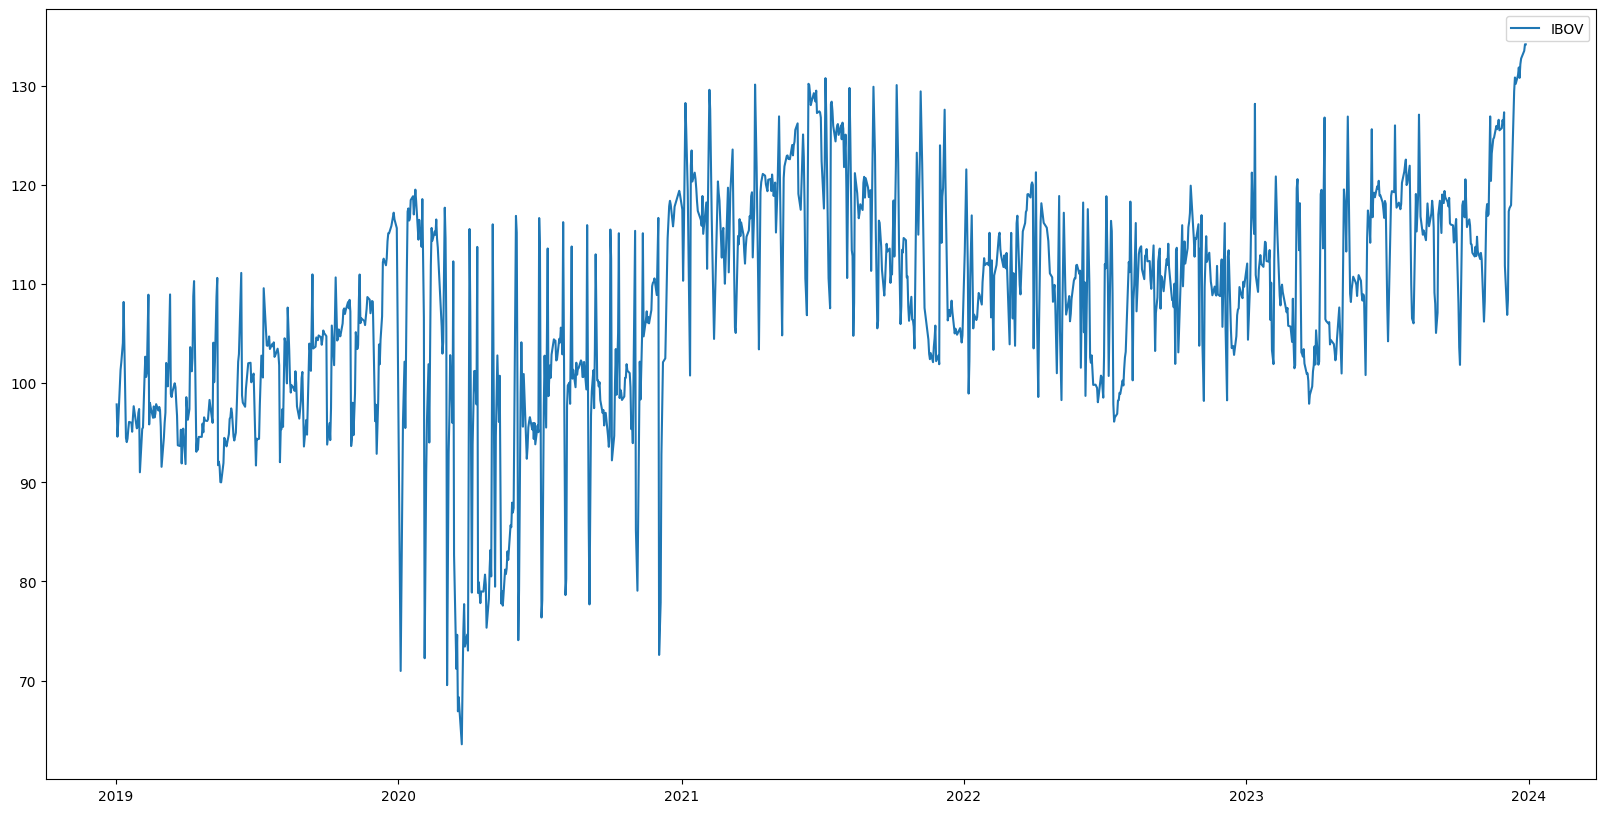

In [9]:
#Ordenando o df por data
df = df.sort_values(by='ds')

plt.figure(figsize = (20,10))
plt.plot(df['ds'], df['y'], label='IBOV')

plt.legend(loc='best')
plt.show()

###Resultados Iniciais

O índice IBOV mínimo nos últimos 5 anos ocorreu no mês de março de 2020, em meio a pandemia de COVID-19. Esse marco negativo não foi uma questão unicamente da bolsa brasileira, visto que mundialmente os mercados colapsavam frente ao assombroso número de mortes e incertezas geradas por um lockdown global. A bolsa brasileira somente retornou aos níveis pré-pandemia no ano de 2021.


O ápice do índice IBOV aconteceu no final do ano de 2023, com uma máxima de 134.19 mil pontos, puxado por uma expectativa global frente a redução das taxas de juros nos Estados Unidos. Localmente, após um ano em que ocorreu a pior série histórica de quedas do índice (13 fechamentos seguidos em queda), o avanço da pauta econômica em Brasília, incluindo o arcabouço fiscal e a reforma tributária, ajudaram a reduzir o receio do mercado e auxiliaram o IBOV a chegar a seu pico.

###Melhorando visualização e sequenciando as análises

Com o fim da pandemia sendo decretado pela ONU no mês de março de 2023 e com as bolsas mundiais já operando em níveis semelhantes ou melhores ao período pré-pandemia, utilizarei os últimos 12 meses completos (ano de 2023) para sequenciar as análises nos modelos preditivos.

In [10]:
#Reduzindo tamanho do df para melhorar a visualização e realizar as análises
df_1y = df[df['ds'].dt.year >= 2023]
df_1y = df_1y.sort_values(by='ds')
df_1y.head()

,ds,y
225,2023-01-02,112.074
207,2023-01-03,104.385
144,2023-01-06,110.565
102,2023-01-08,121.248
79,2023-01-09,117.893


In [11]:
df_1y.shape

(248, 2)

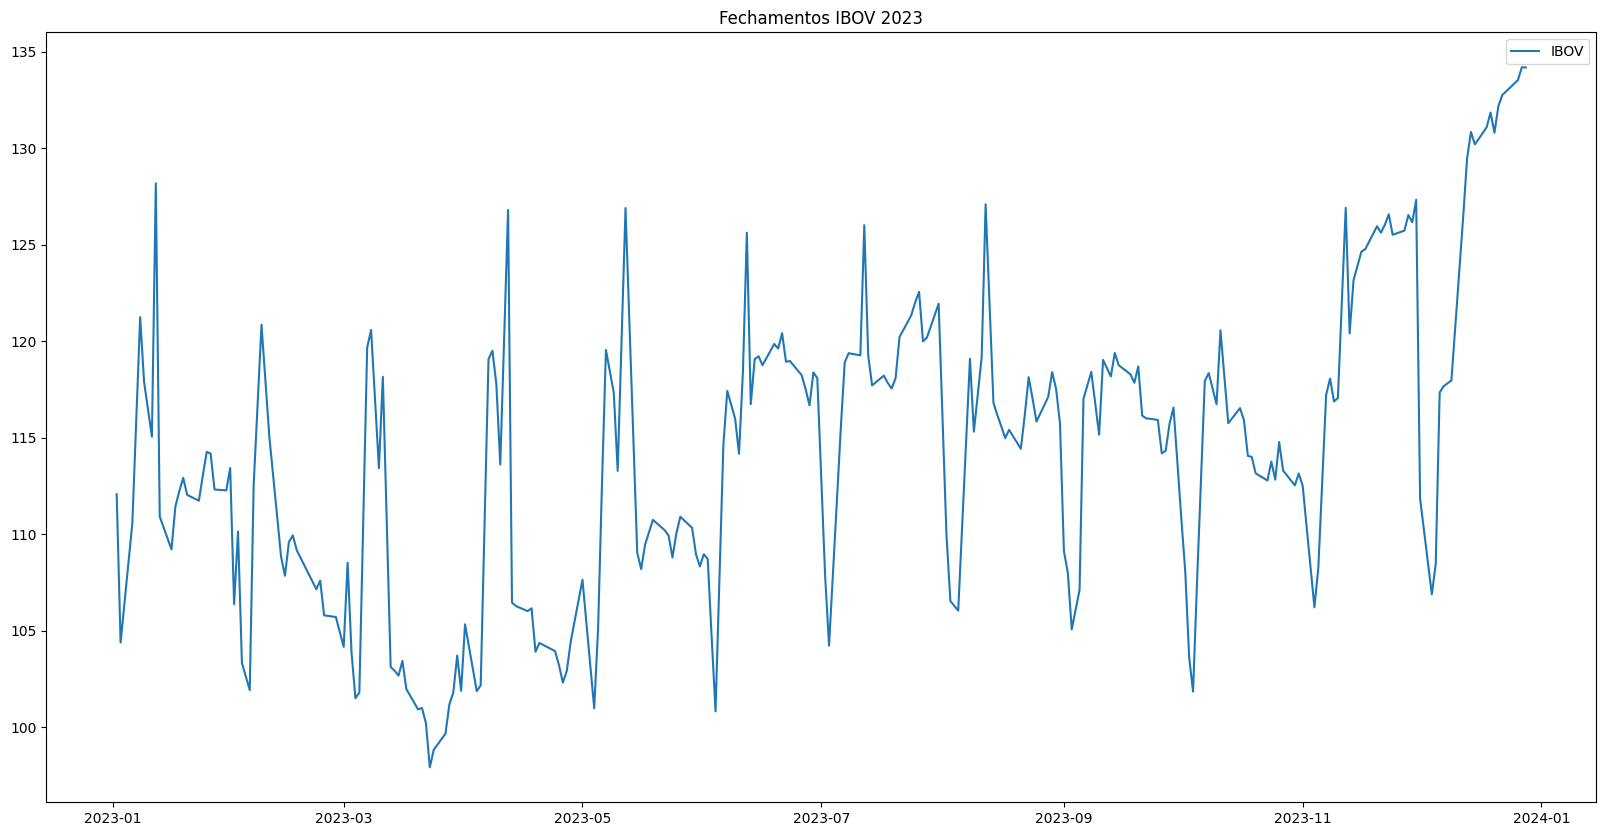

In [12]:
#Vizualizando o comportamento do fechamento do IBOV no último ano
plt.figure(figsize = (20,10))
plt.plot(df_1y['ds'], df_1y['y'], label='IBOV')
plt.title('Fechamentos IBOV 2023')
plt.legend(loc='best')
plt.show()

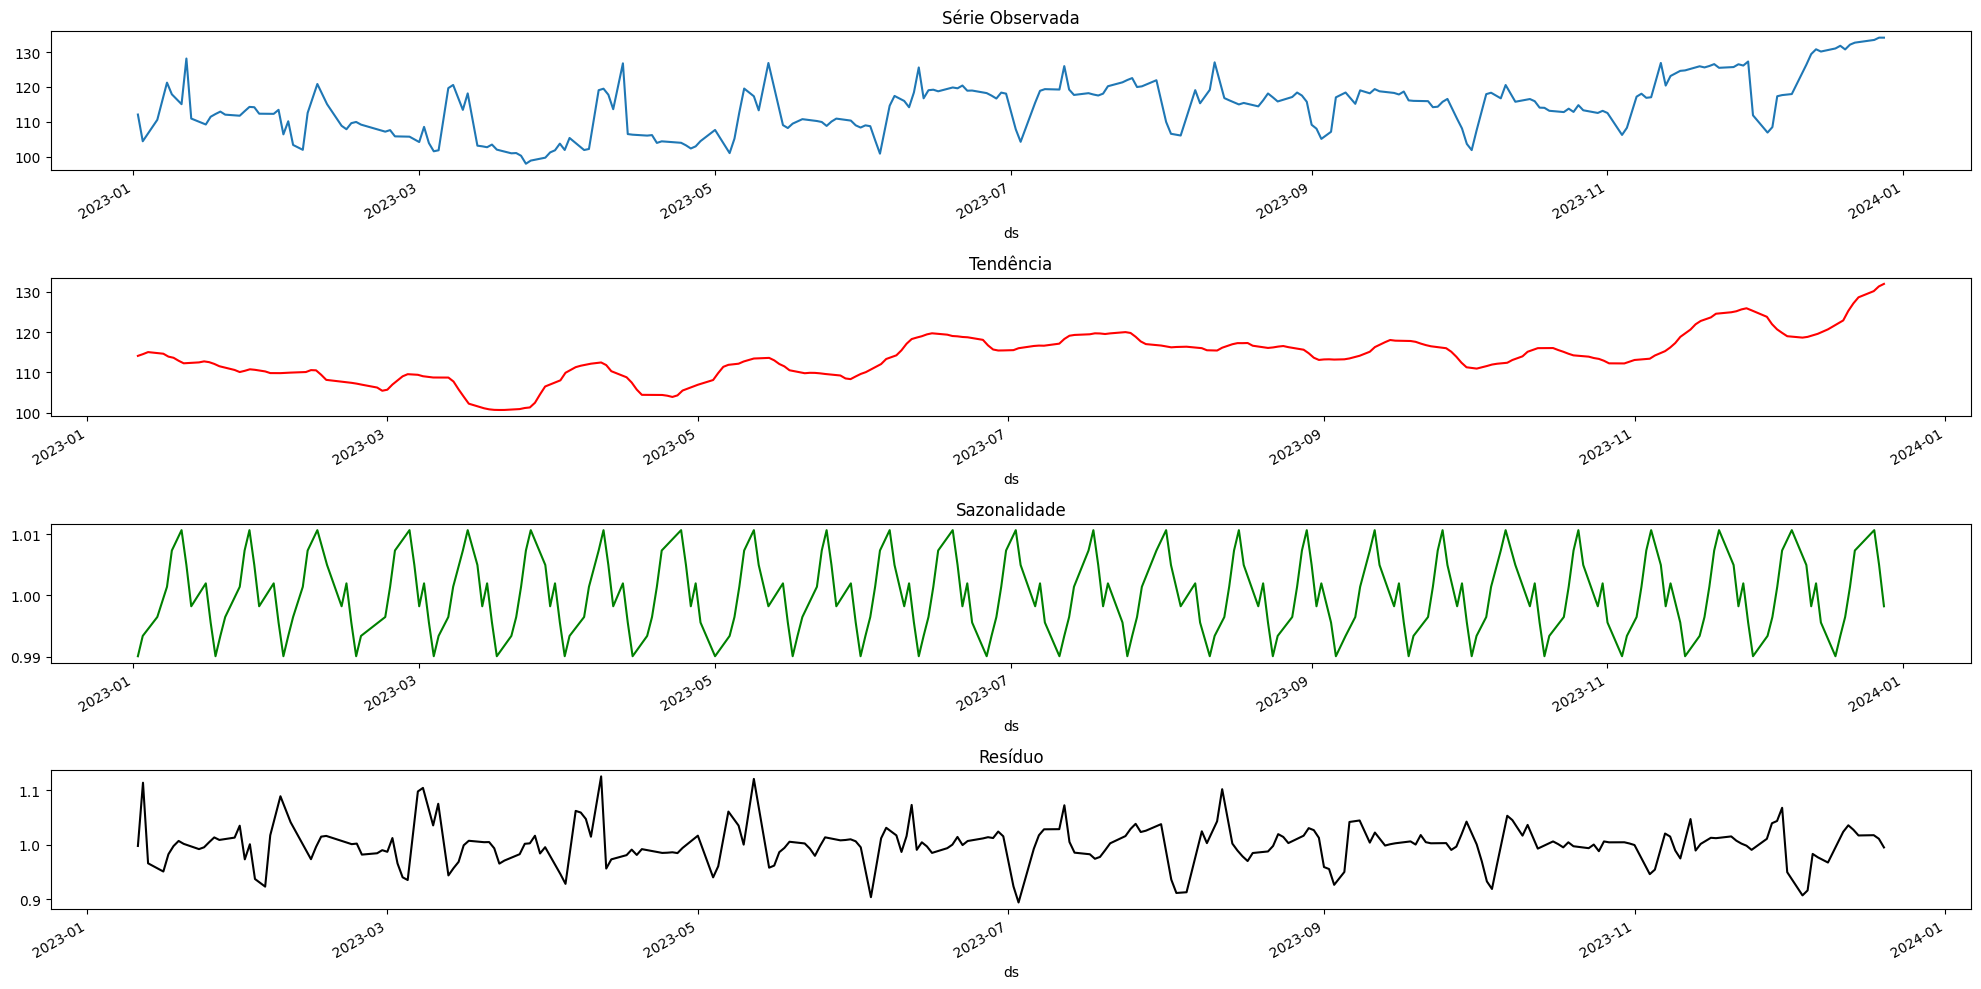

In [13]:
#Criando uma cópia do df já limpo e ajustado para utilizar na análise, mantendo o original salvo para uso posterior
df_1 = df_1y

#Definindo a data como índice para que o modelo rode corretamente
df_1 = df_1.set_index('ds')

#Decompor a série temporal para visualizar os gráficos da série, tendência, sazonalidade e o gráfico com resíduos
seasonplot = seasonal_decompose(df_1, model='multiplicative', period=10)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20,10))
seasonplot.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
seasonplot.trend.plot(ax=ax2, color = 'red')
ax2.set_title('Tendência')
seasonplot.seasonal.plot(ax=ax3, color = 'green')
ax3.set_title('Sazonalidade')
seasonplot.resid.plot(ax=ax4, color = 'black')
ax4.set_title('Resíduo')
plt.tight_layout()

É possível identificar que, ao final de 2023, há uma tendência de alta no índice IBOV

Com o gráfico de Resíduo podemos confirmar que a nossa série possui muita oscilação

##Testando modelos

###Média Móvel

In [14]:
#Criada nova cópia do df original para análise, sem prejudicar as demais
df_2 = df_1y

df_2 = df_2.sort_values(by='ds')

df_2.set_index('ds', inplace = True)

df_2['MA_window_10'] = df_2['y'].rolling(10).mean().shift() #Janela de 10 dias
df_2['MA_window_20'] = df_2['y'].rolling(20).mean().shift() #Janela de 20 dias

df_2.head(20)

,y,MA_window_10,MA_window_20
ds,,,
2023-01-02,112.074,NaN,NaN
2023-01-03,104.385,NaN,NaN
2023-01-06,110.565,NaN,NaN
2023-01-08,121.248,NaN,NaN
2023-01-09,117.893,NaN,NaN
2023-01-11,115.053,NaN,NaN
2023-01-12,128.185,NaN,NaN
2023-01-13,110.916,NaN,NaN
2023-01-16,109.213,NaN,NaN


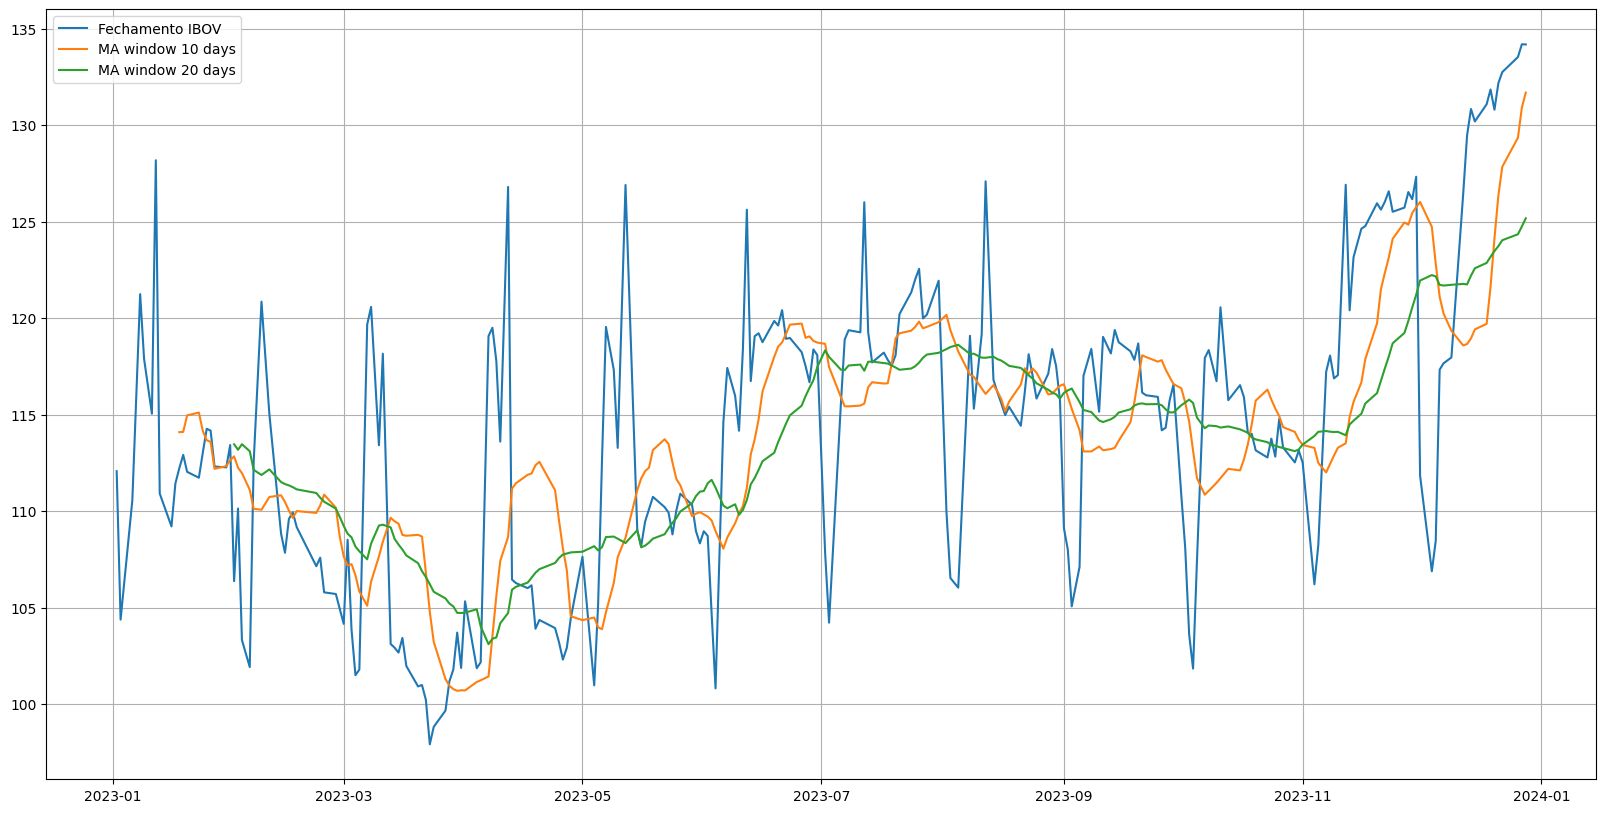

In [15]:
plt.figure(figsize=(20,10))
plt.grid(True)
plt.plot(df_2['y'], label='Fechamento IBOV')
plt.plot(df_2['MA_window_10'], label='MA window 10 days')
plt.plot(df_2['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

In [16]:
#Aparentemente não há muita acuracidade no resultado através da MA, mas podemos realizar uma visualização gráfica através da predição dos próximos 10 dias de janela

df_2['MA_window_10_forward_10'] = np.NaN

In [17]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]

In [18]:
window_size = 10
forward_days = 10

for index in range(window_size, len(df_2), forward_days):

    for i in range(0, forward_days):
        if index + i >= len(df_2):
            break

        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df_2['y'].iloc[window_close], df_2['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df_2.iat[index + i, df_2.columns.get_loc('MA_window_10_forward_10')] = mean

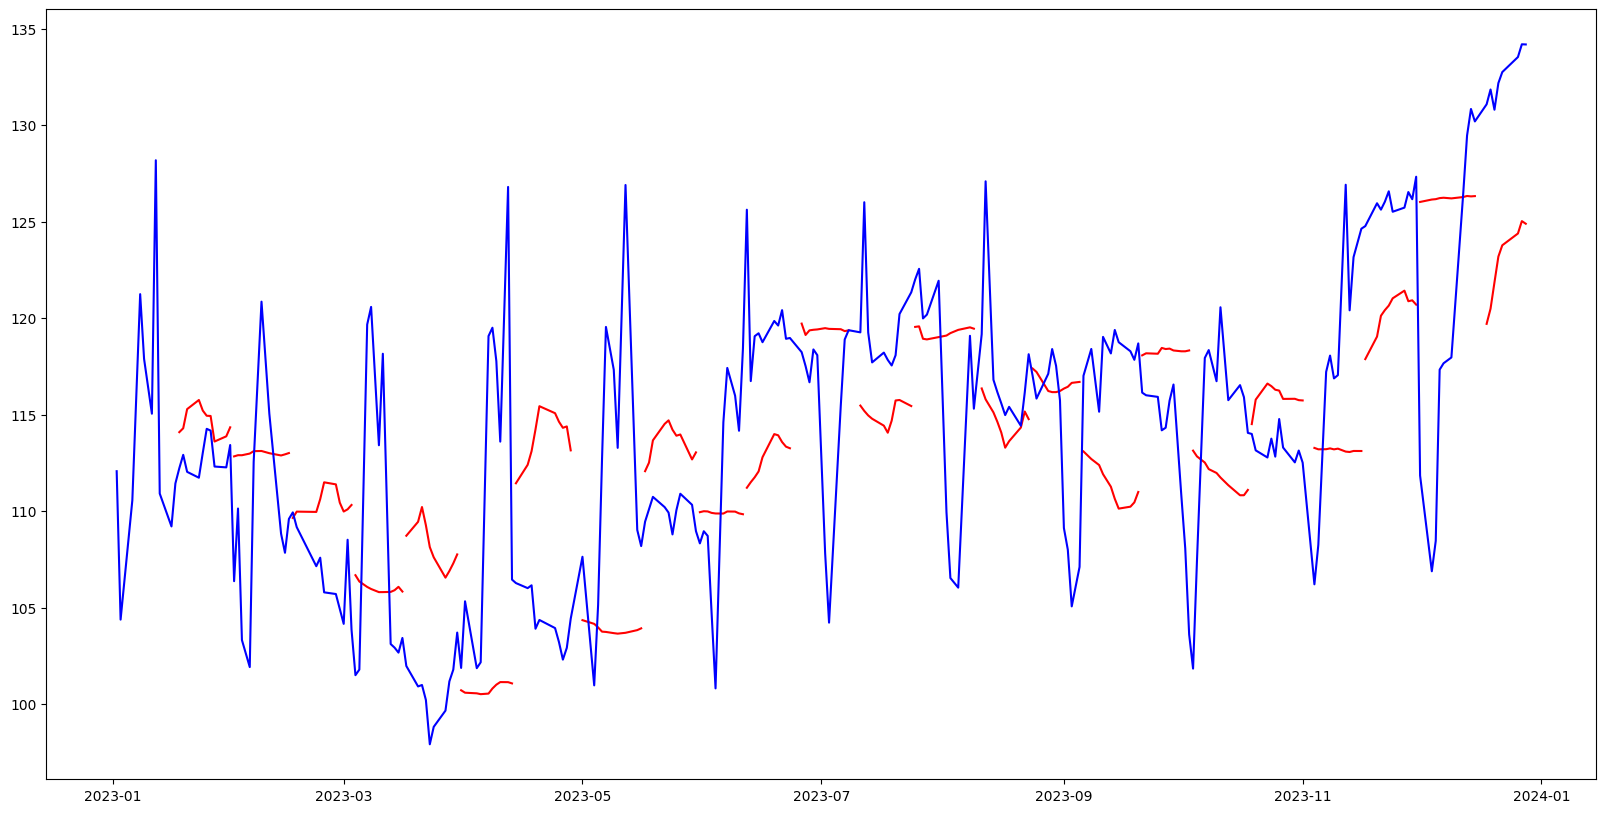

In [19]:
plt.figure(figsize = (20,10))

limit = 248

size = len(df_2)-limit - (len(df_2)-limit)%forward_days

for index in range(size, len(df_2), forward_days):
    plt.plot(df_2['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df_2['y'][-limit:], color='b', label='Fechamento IBOV')
plt.show()

Com o gráfico fica claro que a previsão realizada através da média móvel de 10 dias não tem uma boa acurácia para nossa série.

###Prophet

Buscando maior assertividade e rapidez na análise, busquei a ferramenta Prophet, que foi projetado para análise de séries temporais com muitos pontos de mudança e padrões sazonais.

####Utilizando base de 1 ano

In [20]:
#Iniciei copiando o df gerado anteriormente para realização da análise com Prophet
df_p = df_1y

#Confirmando se os comandos foram aceitos corretamente
df_p.head()


,ds,y
225,2023-01-02,112.074
207,2023-01-03,104.385
144,2023-01-06,110.565
102,2023-01-08,121.248
79,2023-01-09,117.893


In [21]:
#Confirmando o tamanho da base que está sendo utilizada
df_p.shape

(248, 2)

In [22]:
#Separando as bases de treino e teste na proporção 80% 20%

train_data = df_p.sample(frac=0.8, random_state=20)
test_data = df_p.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')


training data size : (198, 2)
testing data size : (50, 2)


In [23]:
#Instanciando o Prophet para utilizar uma sazonalidade diária e gerar previsões

modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2wak5w7/0n6ee4k1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2wak5w7/81ha2m1t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21657', 'data', 'file=/tmp/tmpm2wak5w7/0n6ee4k1.json', 'init=/tmp/tmpm2wak5w7/81ha2m1t.json', 'output', 'file=/tmp/tmpm2wak5w7/prophet_modelyg3skkkh/prophet_model-20240129202959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:29:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,111.281902,100.910720,116.345367,111.281902,111.281902,-2.668663,-2.668663,-2.668663,-2.580238,-2.580238,-2.580238,-0.088425,-0.088425,-0.088425,0.0,0.0,0.0,108.613238
1,2023-01-03,111.270281,101.126157,116.163699,111.270281,111.270281,-2.613930,-2.613930,-2.613930,-2.580238,-2.580238,-2.580238,-0.033692,-0.033692,-0.033692,0.0,0.0,0.0,108.656351
2,2023-01-06,111.235418,102.040051,117.469556,111.235418,111.235418,-1.309302,-1.309302,-1.309302,-2.580238,-2.580238,-2.580238,1.270936,1.270936,1.270936,0.0,0.0,0.0,109.926116
3,2023-01-09,111.200555,100.974682,116.309059,111.200555,111.200555,-2.668663,-2.668663,-2.668663,-2.580238,-2.580238,-2.580238,-0.088425,-0.088425,-0.088425,0.0,0.0,0.0,108.531892
4,2023-01-11,111.177313,100.738264,116.054444,111.177313,111.177313,-2.281273,-2.281273,-2.281273,-2.580238,-2.580238,-2.580238,0.298965,0.298965,0.298965,0.0,0.0,0.0,108.896040


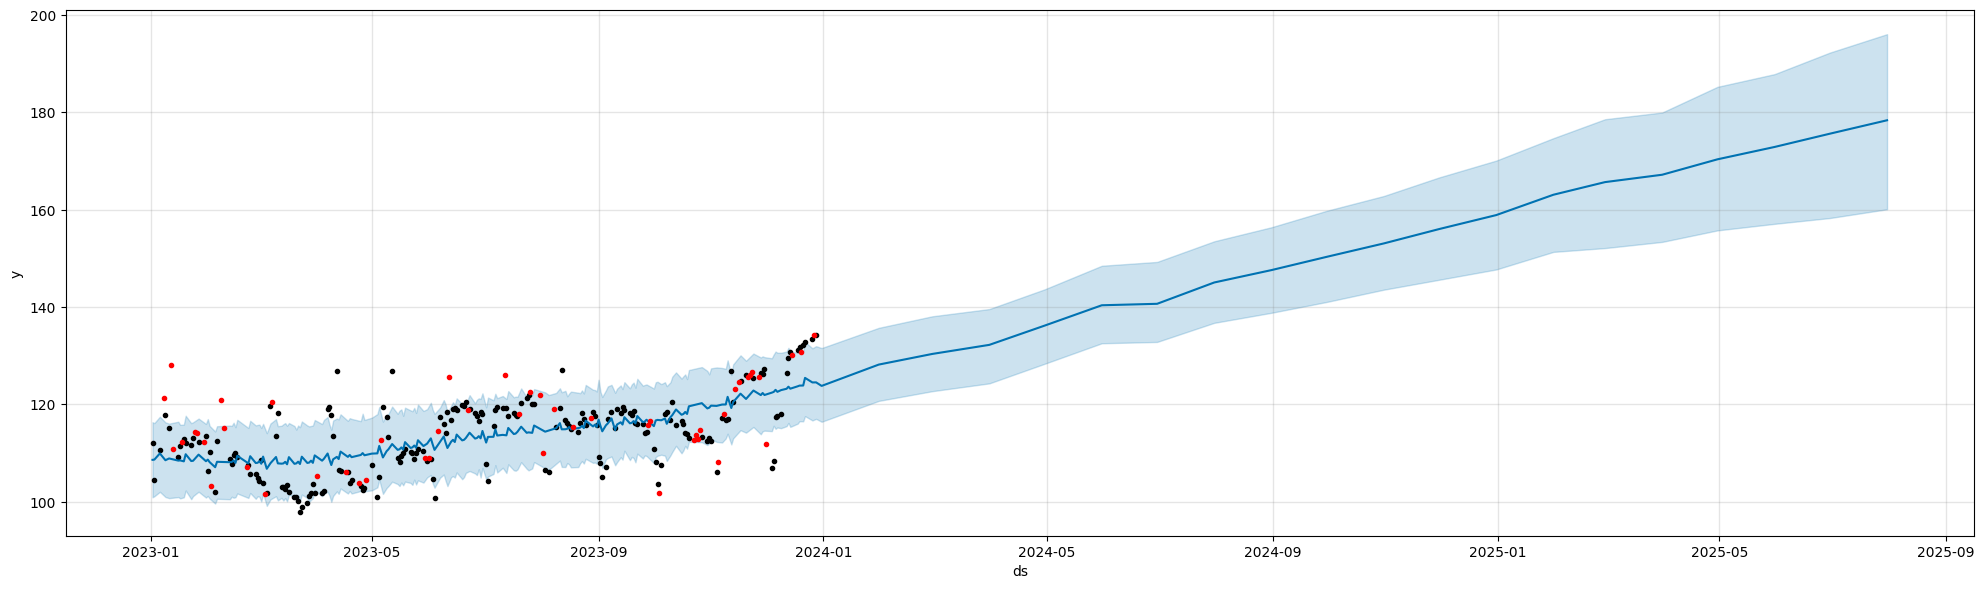

In [24]:
#Visualizando os dados juntamente com as previsões
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

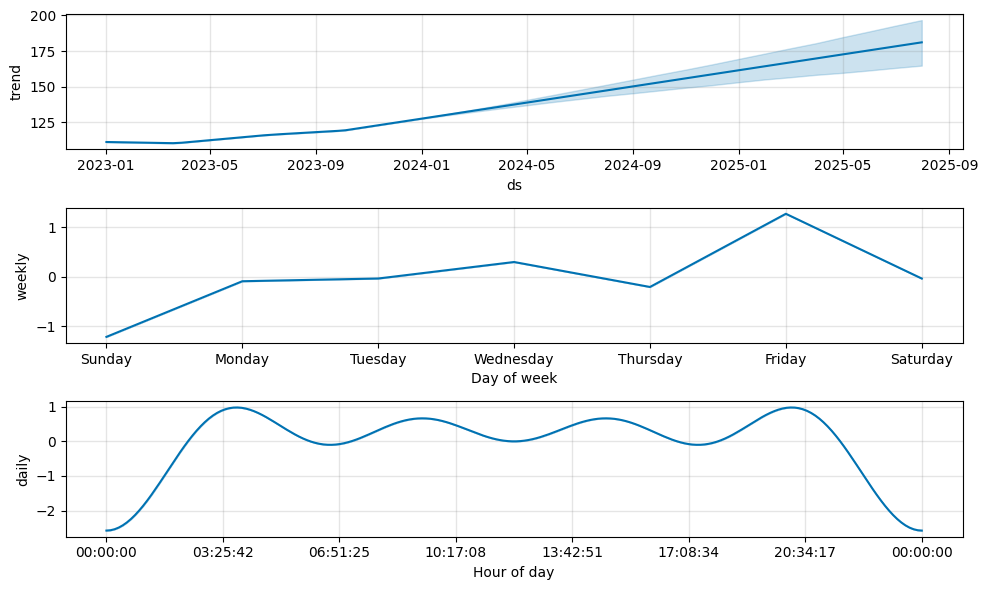

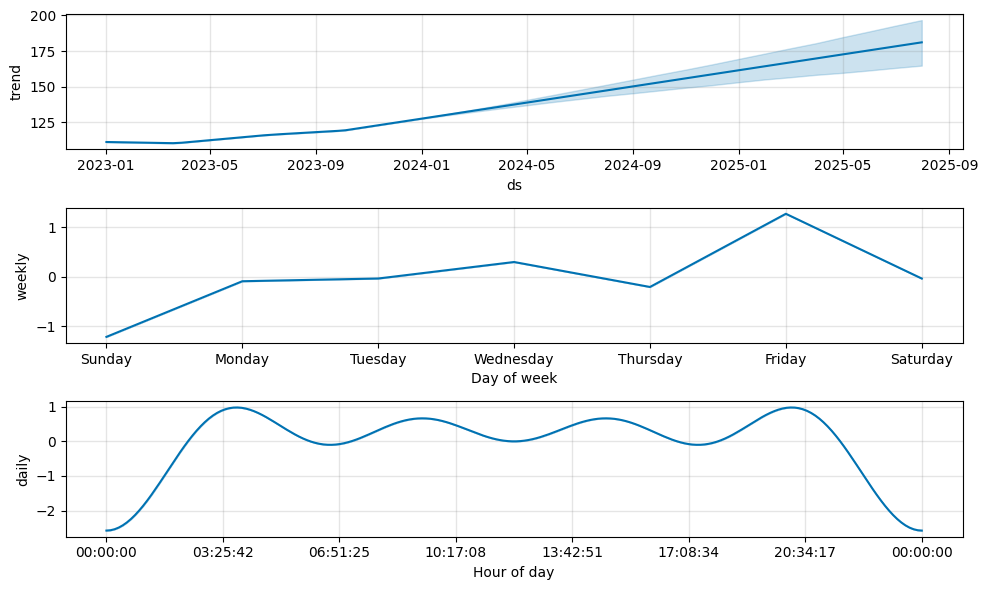

In [25]:
modelo.plot_components(previsao, figsize=(10,6))

In [55]:
#Extraindo as colunas relevantes dos DataFrames e mesclando os DataFrames nas colunas 'ds' para comparar previsões e valores reais
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')


In [56]:
#Calcular o erro percentual absoluto para cada ponto de dados e o MAPE
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 4.27%


####Utilizando base de 3 anos

Como o MAPE utilizando uma base de 1 ano foi baixo, mostrando boa aderência, vou realizar o teste com uma base maior, para identificar qual das duas é melhor para ser utilizada.

In [57]:
#Iniciei filtrando o df original para realização da análise extra com Prophet
df_p2 = df[df['ds'].dt.year >= 2021]
df_p2 = df_p2.sort_values(by='ds')

#Confirmando se os comandos foram aceitos corretamente
df_p2.head()

,ds,y
725,2021-01-02,117.518
707,2021-01-03,110.335
684,2021-01-04,115.253
643,2021-01-06,128.267
622,2021-01-07,125.666


In [58]:
#Confirmando o tamanho da base que está sendo utilizada
df_p2.shape


(745, 2)

In [59]:
#Separando as bases de treino e teste na proporção 80% 20%

train_data2 = df_p2.sample(frac=0.8, random_state=20)
test_data2 = df_p2.drop(train_data2.index)
print(f'training data size : {train_data2.shape}')
print(f'testing data size : {test_data2.shape}')

training data size : (596, 2)
testing data size : (149, 2)


In [60]:
#Instanciando o Prophet para utilizar uma sazonalidade diária e gerar previsões

modelo2 = Prophet(daily_seasonality=True)
modelo2.fit(train_data2)
dataFramefuture = modelo2.make_future_dataframe(periods=20, freq='M')
previsao2 = modelo2.predict(dataFramefuture)
previsao2.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2wak5w7/4evlc9st.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm2wak5w7/vrkr2nex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40027', 'data', 'file=/tmp/tmpm2wak5w7/4evlc9st.json', 'init=/tmp/tmpm2wak5w7/vrkr2nex.json', 'output', 'file=/tmp/tmpm2wak5w7/prophet_modelzagltquh/prophet_model-20240129204414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:44:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:44:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-02,117.575447,111.053606,127.002861,117.575447,117.575447,1.352192,1.352192,1.352192,0.598589,...,0.425067,0.425067,0.425067,0.328536,0.328536,0.328536,0.0,0.0,0.0,118.927638
1,2021-01-03,117.579030,109.431784,125.634217,117.579030,117.579030,-0.334195,-0.334195,-0.334195,0.598589,...,-1.211938,-1.211938,-1.211938,0.279154,0.279154,0.279154,0.0,0.0,0.0,117.244835
2,2021-01-04,117.582614,111.227956,125.617924,117.582614,117.582614,1.159570,1.159570,1.159570,0.598589,...,0.329763,0.329763,0.329763,0.231219,0.231219,0.231219,0.0,0.0,0.0,118.742185
3,2021-01-06,117.589782,111.314775,127.163683,117.589782,117.589782,1.411882,1.411882,1.411882,0.598589,...,0.668647,0.668647,0.668647,0.144647,0.144647,0.144647,0.0,0.0,0.0,119.001664
4,2021-01-07,117.593365,110.616994,126.276384,117.593365,117.593365,0.913023,0.913023,0.913023,0.598589,...,0.206296,0.206296,0.206296,0.108139,0.108139,0.108139,0.0,0.0,0.0,118.506388


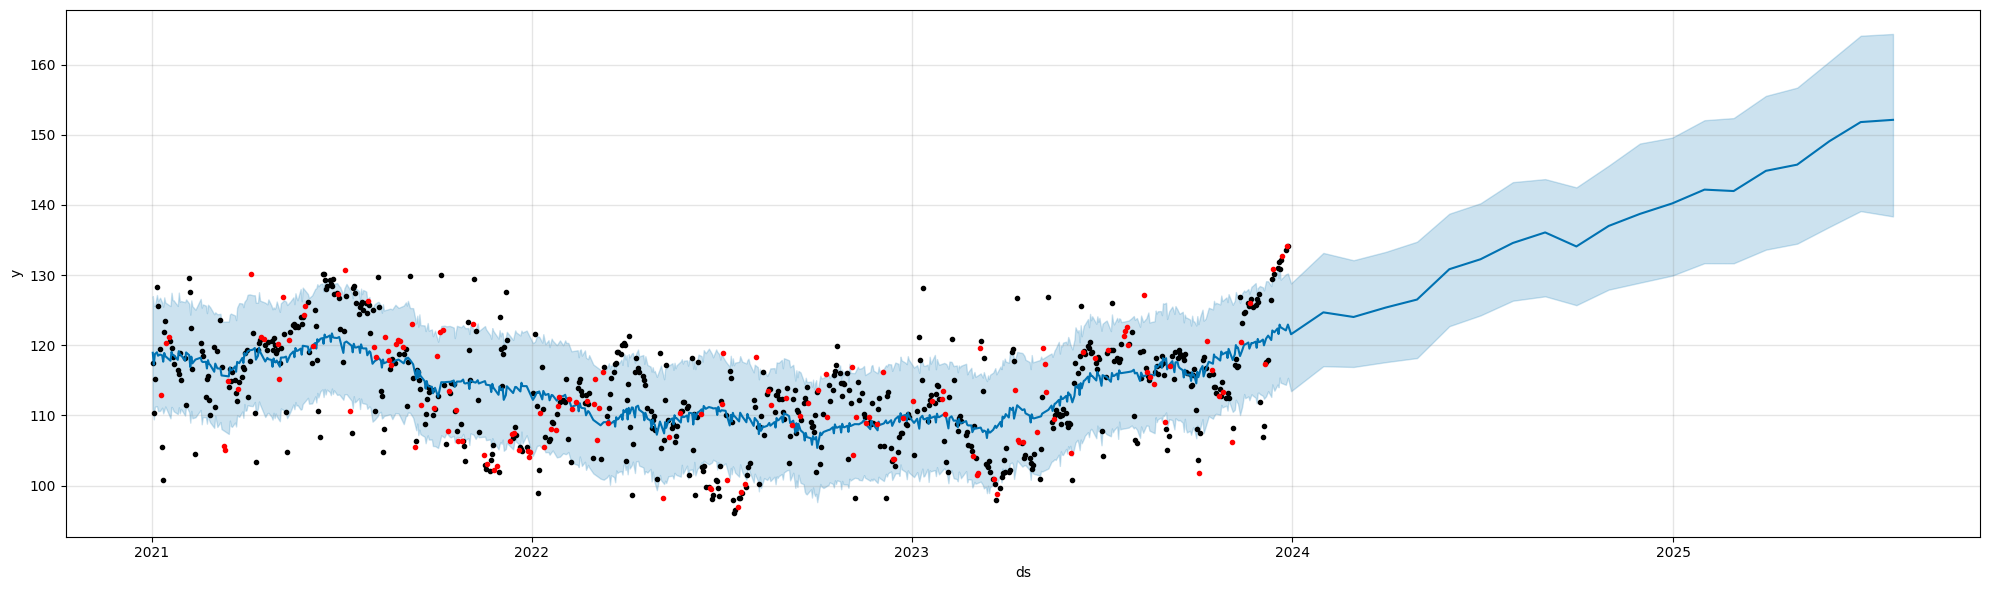

In [61]:
#Visualizando os dados juntamente com as previsões
modelo2.plot(previsao2, figsize=(20,6));
plt.plot(test_data2['ds'], test_data2['y'], '.r')

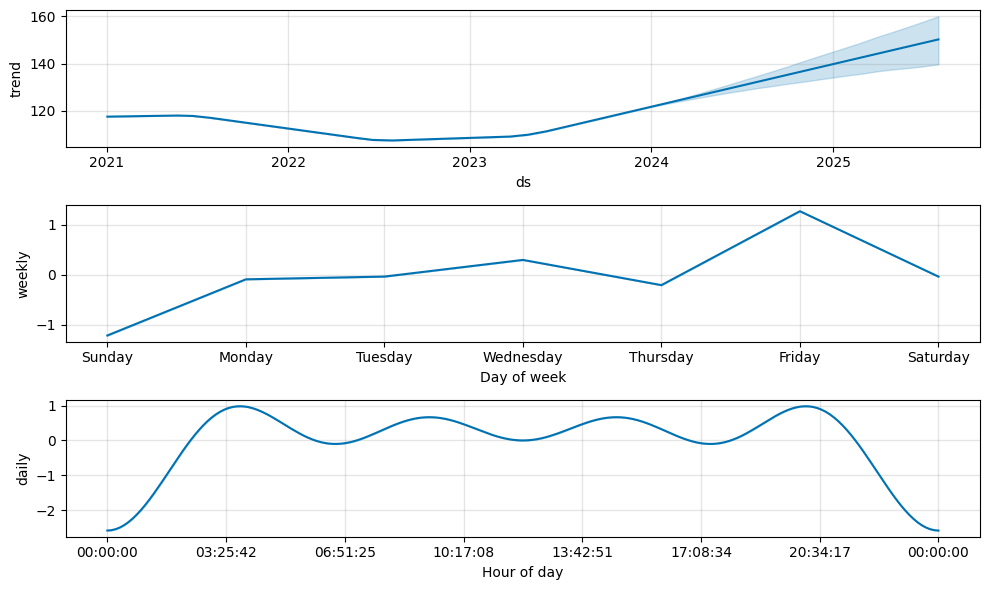

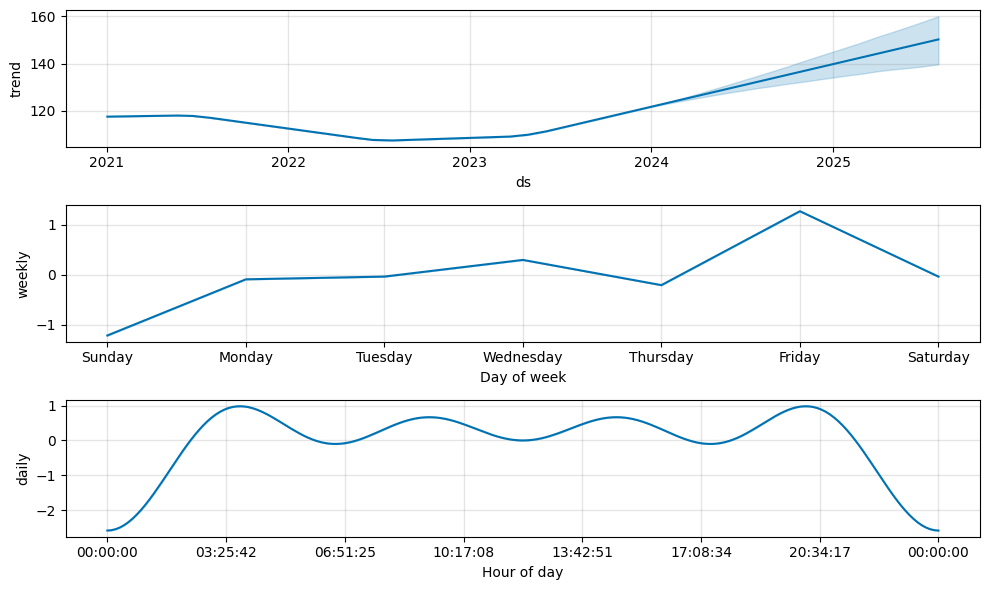

In [62]:
modelo.plot_components(previsao2, figsize=(10,6))

In [63]:
#Extraindo as colunas relevantes dos DataFrames e mesclando os DataFrames nas colunas 'ds' para comparar previsões e valores reais
previsao_cols2 = ['ds', 'yhat']
valores_reais_cols2 = ['ds', 'y']

previsao2 = previsao2[previsao_cols2]
valores_reais2 = train_data2[valores_reais_cols2]

resultados2 = pd.merge(previsao2, valores_reais2, on='ds', how='inner')

In [64]:
#Calcular o erro percentual absoluto para cada ponto de dados e o MAPE
resultados2['erro_percentual_absoluto'] = np.abs((resultados2['y'] - resultados2['yhat']) / resultados2['y']) * 100

mape2 = np.mean(resultados2['erro_percentual_absoluto'])

print(f"MAPE: {mape2:.2f}%")

MAPE: 4.36%


Utilizar um período maior de tempo não trouxe melhora ao modelo, havendo uma redução de 0.09% da acuracidade, algo significativamente irrelevante, mas que não nos dá fundamentos para que essa série temporal maior seja utilizada como base para a análise.

##Conclusão

O melhor modelo para análise dos dados foi através do Prophet, com uma janela de fechamento IBOV de 1 ano, nos apresentando um MAPE (Erro Percentual Médio Absoluto) de 4,27%, ficando dentro dos 70% de acuracidade do modelo solicitados no envio da demanda.